## Configuration

### Imports

In [7]:
# Utilities
from IPython.display import display
import os
import numpy as np
import time
import pandas as pd
from fastprogress import master_bar, progress_bar

# MongoDB functionality
from pymongo import MongoClient, InsertOne, UpdateOne
from bson import ObjectId
from collections.abc import MutableMapping

# Graphics
import matplotlib.pyplot as plt
from matplotlib.pyplot import text
import seaborn as sns
sns.set(font_scale=0.9)
sns.set_style("whitegrid")
sns.set_style({'font.family':'monospace'})
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


# Date Graphics
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.dates import date2num


# Network analysis
import networkx as nx

ROOT_DIR = "/home/mattia/javier/botbusters-spanish-general-elections-network-analysis/"

# Change path to root
os.chdir(ROOT_DIR)

# MongoDB parameters
mongoclient = MongoClient('localhost', 27017)
db = mongoclient.influence

### Support Functions

In [8]:
def flatten(d, parent_key='', sep='_'):
    """Formats MongoDB results
    
    Keyword arguments:
    d -- dictionary with key and uncleaned values
    parent_key --
    sep --
    """
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, MutableMapping):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

def make_objid(text):
    """Makes an ObjectId of 4 bytes
    
    Keyword arguments:
    text -- string to be converted into Object ID
    """
    text = str(text)
    if not text.strip():
        return None
    try:
        return ObjectId(text.rjust(24,"0"))
    except Exception as ex:
        print(text, ex)
        return None
    
def get_tweets(collection):
    """
    Gets tweets
    
    collection - Tweets MongoDB collection
    """
    tweets = list(collection
                    .find({'sampled':True},{'_id': False, 'tweet_id': True, 'user_id' : True, 'date':True})
                   )
    
    print("Number of tweets:", len(tweets))
    tweets = [flatten(t) for t in tweets]
    df_tweets = pd.DataFrame(tweets)
    df_tweets.user_id = df_tweets.user_id.apply(lambda t : str(t))
    df_tweets.user_id = df_tweets.user_id.astype(str)
    df_tweets.date = df_tweets.date.astype("datetime64")
    return df_tweets
    
    
def get_retweets(collection):
    """
    Gets retweets
    
    collection - Retweets MongoDB collection
    """
    retweets = list(collection
                    .find({'sampled':True},{'_id': False, 'tweet_id': True, 'user_id' : True, 'date':True})
                   )
    
    print("Number of retweets:", len(retweets))
    retweets = [flatten(r) for r in retweets]
    df_retweets = pd.DataFrame(retweets)
    df_retweets.user_id = df_retweets.user_id.apply(lambda t : str(t))
    df_retweets.user_id = df_retweets.user_id.astype(str)
    df_retweets.date = df_retweets.date.astype("datetime64")
    return df_retweets

def get_users(collection):
    """
    Gets users
    
    collection - Users MongoDB collection
    """
    users = list(collection.find({ '$and' : [ { 'sampled': True } , { 'botscore' : { '$gte' : 0 } }]},
                                 {'_id' : True, 'botscore' : True})
                )

    print("Number of sampled users with botscore in DB:", len(users))
    users = [flatten(u) for u in users]
    df_users = pd.DataFrame(users)
    df_users._id = df_users._id.apply(lambda t : str(t))
    df_users._id = df_users._id.astype(str)
    return df_users

def reindex_by_date(df):
    """Reindexes a DataFrame by date
    
    Keyword arguments:
    df -- DataFrame to be reindexed by date
    """
    dates = pd.date_range(xlim[0], xlim[1],name='created_at')
    return df.reindex(dates,fill_value=0)

def daterange(start_date, end_date):
    """Creates a generator of days to be used in loops
    
    Keyword arguments:
    start_date -- First date to be generated
    end_date -- Last date to be generated
    """
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)

## Data preparation

#### Getting tweets from database

In [9]:
df_tweets = get_tweets(db.tweets)
df_tweets.head(3)

Number of tweets: 358190


,user_id,date,tweet_id
0,000000000000000279465279,2019-11-04 21:15:49,000001191464087064109058
1,000000000000001266667238,2019-11-08 12:53:41,000001192787272975945729
2,000000000000000331220696,2019-11-04 21:28:10,000001191467194519080960


In [10]:
df_tweets[df_tweets.duplicated()].count()
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358190 entries, 0 to 358189
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   user_id   358190 non-null  object        
 1   date      358190 non-null  datetime64[ns]
 2   tweet_id  358190 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 8.2+ MB


In [11]:
df_tweets.drop_duplicates(keep='first', inplace=True)

#### Getting retweets from database

In [12]:
df_retweets = get_retweets(db.retweets)
df_retweets.head(3)

Number of retweets: 7868861


,tweet_id,user_id,date
0,000001193667913368121351,000000000000004460826197,2019-11-10 23:15:43
1,000001192581634291355649,000001075150211725619200,2019-11-07 23:20:20
2,000001190659978471911424,000000000000000071190801,2019-11-02 16:54:42


In [13]:
df_retweets[df_retweets.duplicated()].count()

tweet_id    2
user_id     2
date        2
dtype: int64

In [14]:
df_retweets.drop_duplicates(keep='first', inplace=True)
df_retweets.count()

tweet_id    7868859
user_id     7868859
date        7868859
dtype: int64

#### Getting users from database

In [15]:
users = get_users(db.users)
display(users.head(5))
users_botscore = dict(zip(users._id, users.botscore))

Number of sampled users with botscore in DB: 1150709


,_id,botscore
0,000000000000002266588688,0.16
1,000000000000000471028961,0.03
2,000000000000002792368467,0.11
3,000000000000004068857357,0.01
4,000000000000000006953012,0.03


## 1. Number of interactions per day

#### Getting retweets + tweets, date and botscores

In [16]:
display(df_tweets.info())
display(df_retweets.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 358190 entries, 0 to 358189
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   user_id   358190 non-null  object        
 1   date      358190 non-null  datetime64[ns]
 2   tweet_id  358190 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 10.9+ MB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7868859 entries, 0 to 7868860
Data columns (total 3 columns):
 #   Column    Dtype         
---  ------    -----         
 0   tweet_id  object        
 1   user_id   object        
 2   date      datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 240.1+ MB


None

In [17]:
df_traffic = df_tweets.append(df_retweets, ignore_index=True)
df_traffic['date'] = df_traffic.date.dt.date
df_traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8227049 entries, 0 to 8227048
Data columns (total 3 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   user_id   object
 1   date      object
 2   tweet_id  object
dtypes: object(3)
memory usage: 188.3+ MB


In [18]:
start = pd.to_datetime(pd.to_datetime('10/04/2019').strftime(format='%Y-%m-%d'))
end = pd.to_datetime(pd.to_datetime('11/11/2019').strftime(format='%Y-%m-%d'))
print(start, end)

2019-10-04 00:00:00 2019-11-11 00:00:00


In [19]:
# filter days
df_traffic = df_traffic[(df_traffic.date <= end) & (df_traffic.date >= start)]
xlim = (df_traffic.date.min(), df_traffic.date.max())
print(xlim)
df_traffic.head()

(datetime.date(2019, 10, 4), datetime.date(2019, 11, 11))


,user_id,date,tweet_id
0,000000000000000279465279,2019-11-04,000001191464087064109058
1,000000000000001266667238,2019-11-08,000001192787272975945729
2,000000000000000331220696,2019-11-04,000001191467194519080960
3,000000000000001452965868,2019-10-31,000001189959990624292868
4,000000978377302286401537,2019-10-11,000001182607615752396800


In [20]:
df_traffic['botscore'] = df_traffic.user_id.map(users_botscore)
df_traffic['botscore'] = df_traffic.botscore.round(decimals=1)
df_traffic.head()

,user_id,date,tweet_id,botscore
0,000000000000000279465279,2019-11-04,000001191464087064109058,0.0
1,000000000000001266667238,2019-11-08,000001192787272975945729,0.2
2,000000000000000331220696,2019-11-04,000001191467194519080960,0.1
3,000000000000001452965868,2019-10-31,000001189959990624292868,0.7
4,000000978377302286401537,2019-10-11,000001182607615752396800,NaN


In [21]:
df_traffic = df_traffic.dropna(axis='index', how='any').sort_values(by='date', ascending=True)

In [22]:
prs = [70,90]
ps = np.percentile(a=df_traffic.drop_duplicates(subset='user_id').botscore, q=prs, interpolation='lower')
print(ps)

[0.2 0.4]


In [23]:
def interval(row):
    if row['botscore'] < ps[0]:
        return 'Likely human'
    elif row['botscore'] < ps[1]:
        return 'Human-Bot transition'
    else:
        return 'Likely bot'

In [24]:
df_traffic['botscore interval'] = df_traffic.apply(lambda row : interval(row), axis=1)
df_traffic.head()

,user_id,date,tweet_id,botscore,botscore interval
171101,000000000000002615419165,2019-10-04,000001180058636715995136,0.3,Human-Bot transition
1725656,000000000000000301536651,2019-10-04,000001180193426362585089,0.3,Human-Bot transition
1725658,000000000000000245728439,2019-10-04,000001180193426362585089,0.1,Likely human
1725659,000000908711303161708550,2019-10-04,000001180193426362585089,0.1,Likely human
1725660,000000000000000401296724,2019-10-04,000001180193426362585089,0.1,Likely human


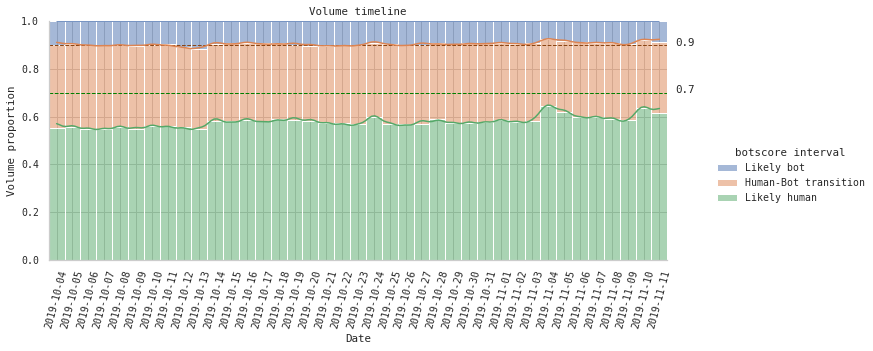

In [25]:
# plot
ax = sns.displot(data=df_traffic,
                   x='date', 
                   hue='botscore interval',
               hue_order=['Likely bot','Human-Bot transition', 'Likely human'],

                  kde=True,
                   multiple="fill",
                  height=5,
                aspect=2)

plt.title('Volume timeline')
ax.set_axis_labels("Date", "Volume proportion")
ax.ax.xaxis.set_major_locator(mdates.DayLocator()) #bymonthday=range(1,30,3)
ax.ax.xaxis.set_tick_params(rotation=75)


colors={prs[0]:'green',
        prs[1]:'saddlebrown'}
h_xlims = ax.ax.get_xlim()
for pr,p in zip(prs,ps):
    ax.ax.hlines(y=pr/100, xmin=h_xlims[0], xmax=h_xlims[1], linewidth = 1, linestyles='dashed',color=colors[pr])
    text(y=pr/100+0.01, x=h_xlims[1]+0.5, s= str(pr/100), verticalalignment='center')

ax.tight_layout()
ax.savefig("images/volume-timeline-fill.svg", bbox_inches = "tight")

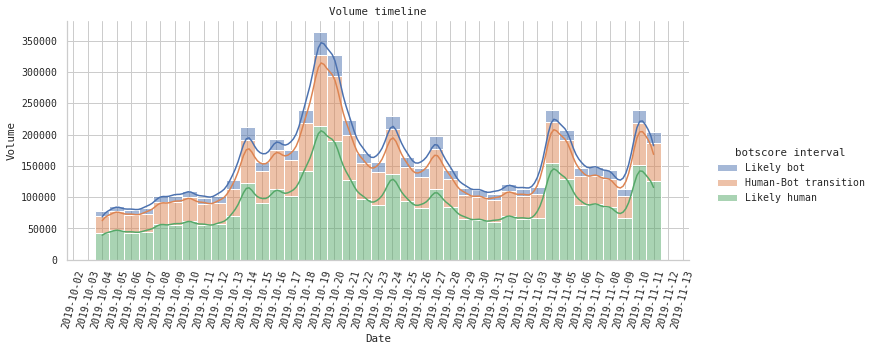

In [26]:
# plot
ax = sns.displot(data=df_traffic,
                   x='date', 
                   hue='botscore interval',
                hue_order=['Likely bot','Human-Bot transition', 'Likely human'],
                  kde=True,
                   multiple="stack",
                  height=5,
                aspect=2)

plt.title('Volume timeline')
ax.set_axis_labels("Date", "Volume")
ax.ax.xaxis.set_major_locator(mdates.DayLocator()) #bymonthday=range(1,30,3)
ax.ax.xaxis.set_tick_params(rotation=75)
ax.tight_layout()
ax.savefig("images/volume-timeline-stack.svg", bbox_inches = "tight")

#### Build directed-weighted retweet graph

In [27]:
df_retweets['botscore'] = df_retweets.user_id.map(users_botscore)
df_edges = df_retweets[['tweet_id','date','user_id','botscore']].rename({'user_id':'retweeter_id'}, axis='columns').set_index('tweet_id').join(df_tweets.rename({'user_id':'retweeted_id'}, axis='columns')[['tweet_id','retweeted_id']].set_index('tweet_id')).reset_index(drop=True)
df_edges.head(5)

,date,retweeter_id,botscore,retweeted_id
0,2019-05-03 19:58:27,000001041608534734061568,0.24,000000000000000068740712
1,2019-05-03 20:03:37,000000000000002824508322,0.08,000000000000000068740712
2,2019-05-03 20:30:39,000000755192640321314817,0.21,000000000000000068740712
3,2019-05-03 20:49:54,000000000000000523370717,NaN,000000000000000068740712
4,2019-05-03 20:54:27,000000000000003610966882,0.09,000000000000000068740712


### Retweet interactions in three main events

In [28]:
situations = {
    0 : [ pd.to_datetime(pd.to_datetime('10/19/2019').strftime(format='%Y-%m-%d')),  pd.to_datetime(pd.to_datetime('10/20/2019').strftime(format='%Y-%m-%d'))],
    1 : [ pd.to_datetime(pd.to_datetime('11/04/2019').strftime(format='%Y-%m-%d')),  pd.to_datetime(pd.to_datetime('11/05/2019').strftime(format='%Y-%m-%d'))],
    2 : [ pd.to_datetime(pd.to_datetime('11/10/2019').strftime(format='%Y-%m-%d')),  pd.to_datetime(pd.to_datetime('11/11/2019').strftime(format='%Y-%m-%d'))],
}

In [29]:
for sit in [0, 1, 2]:
    df_situation = df_edges[(df_edges.date >= situations[sit][0]) & (df_edges.date <= situations[sit][1])]
    df_situation = df_situation.groupby(['retweeter_id','retweeted_id']).size().reset_index().rename(columns={0:'weight'})
    
    implicated_users = []
    implicated_users = list(set(list(df_situation.retweeter_id.unique()) + list(df_situation.retweeted_id.unique())))
    #print("Implicated users:", len(implicated_users))
    
    df_users = users[users._id.isin(implicated_users)]
    print("Users with botscore:", len(df_users))
    
    
    df_situation = df_situation[(df_situation.retweeted_id.isin(df_users._id)) & (df_situation.retweeter_id.isin(df_users._id))]
    print("Retweets with botscore:", len(df_situation))
    
    #display(df_users.head())
    #display(df_situation.head())
    
    G = nx.from_pandas_edgelist(df=df_situation, source='retweeted_id', target='retweeter_id', edge_attr='weight', create_using=nx.DiGraph)
    #nx.set_node_attributes(G, values=-1, name='botscore')
    node_attr = df_users.set_index('_id').to_dict('index')
    nx.set_node_attributes(G, node_attr)
    nx.write_graphml(G, f"graphs/kcore-situation{sit}.graphml")

Users with botscore: 169141
Retweets with botscore: 286635
Users with botscore: 109141
Retweets with botscore: 180170
Users with botscore: 131325
Retweets with botscore: 187256


## 2. Analysis of spreading cores

In [30]:
df_retweets['botscore'] = df_retweets.user_id.map(users_botscore)

df_edges = df_retweets[['tweet_id','date','user_id','botscore']].rename({'user_id':'retweeter_id'}, axis='columns').set_index('tweet_id').join(df_tweets.rename({'user_id':'retweeted_id'}, axis='columns')[['tweet_id','retweeted_id']].set_index('tweet_id')).reset_index(drop=True)
df_kcore = df_edges.groupby(['retweeter_id','retweeted_id']).size().reset_index().rename(columns={0:'weight'})

implicated_users = []
implicated_users = list(set(list(df_kcore.retweeter_id.unique()) + list(df_kcore.retweeted_id.unique())))
#print("Implicated users:", len(implicated_users))

df_users = users[users._id.isin(implicated_users)]
print("Users with botscore:", len(df_users))

print("Total retweets", len(df_kcore))
df_kcore = df_kcore[(df_kcore.retweeted_id.isin(df_users._id)) & (df_kcore.retweeter_id.isin(df_users._id))]
print("Retweets with botscore:", len(df_kcore))

Users with botscore: 1150709
Total retweets 6037031
Retweets with botscore: 4313219


In [31]:
G = nx.from_pandas_edgelist(df=df_kcore, source='retweeted_id', target='retweeter_id', edge_attr='weight', create_using=nx.DiGraph)

node_attr = df_users.set_index('_id').to_dict('index')
nx.set_node_attributes(G, node_attr)

In [32]:
#remove self loops for kshell
G.remove_edges_from(nx.selfloop_edges(G))

In [33]:
df_botscores = pd.DataFrame.from_records(list(G.nodes(data='botscore')), columns=['user','botscore'])
df_botscores.head(2)

,user,botscore
0,000000000000000026994875,0.06
1,000000000000000000002862,0.09


In [34]:
%%time
df_cores = pd.DataFrame(nx.core_number(G).items(), columns=['user','k-core'])
df_cores.head(2)

CPU times: user 6min 1s, sys: 1.07 s, total: 6min 2s
Wall time: 6min 2s


,user,k-core
0,000000000000000026994875,17
1,000000000000000000002862,1


In [35]:
df_cores = df_cores.merge(df_botscores, on='user')
df_cores.sample(5)

,user,k-core,botscore
717911,000000000000003643897816,1,0.19
139505,000000000000000156512698,2,0.01
704236,000000000000003322986941,17,0.07
776942,000000772563672292089856,1,0.05
508489,000000000000001067530544,1,0.23


In [36]:
df_cores['k-core'].describe()

count    1.027305e+06
mean     4.239890e+00
std      9.794127e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      3.000000e+00
max      9.700000e+01
Name: k-core, dtype: float64

CPU times: user 5min 27s, sys: 2min 22s, total: 7min 49s
Wall time: 5min 29s


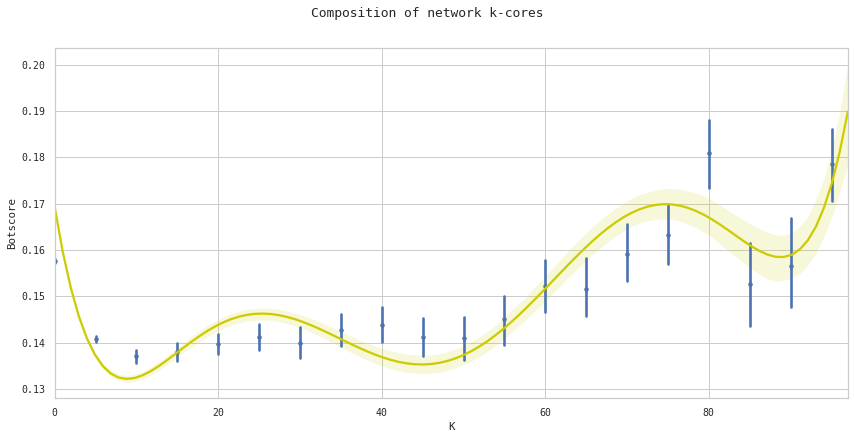

In [54]:
%%time
fig, axs = plt.subplots(1, 1, figsize=(12,6))

ax = sns.regplot(x='k-core',
            y='botscore',
            data=df_cores,
            x_bins=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100],
            scatter_kws = {'color': 'b', 's':12},
            line_kws = {'color': '#CCCC00'},
            order=6
           )

ax.set_ylabel(ylabel='Botscore')
ax.set_xlabel(xlabel='K')
fig.suptitle("Composition of network k-cores", y=1.01)
plt.tight_layout()
plt.savefig("images/kcores.svg")

In [47]:
prs = [70,90]
ps = np.percentile(a=df_cores.drop_duplicates(subset='user').botscore, q=prs, interpolation='lower')
print(ps)

[0.19 0.37]


In [48]:
def interval(row):
    if row['botscore'] < ps[0]:
        return 'Likely human'
    elif row['botscore'] < ps[1]:
        return 'Human-Bot transition'
    else:
        return 'Likely bot'

In [49]:
df_cores['User nature'] = df_cores.apply(lambda row : interval(row), axis=1)
df_cores.head()

,user,k-core,botscore,User nature
0,000000000000000026994875,17,0.06,Likely human
1,000000000000000000002862,1,0.09,Likely human
2,000000000000000014436030,93,0.01,Likely human
3,000000000000000000003968,1,0.05,Likely human
4,000000000000000035222818,22,0.24,Human-Bot transition


CPU times: user 33.4 s, sys: 7.11 s, total: 40.5 s
Wall time: 30.8 s


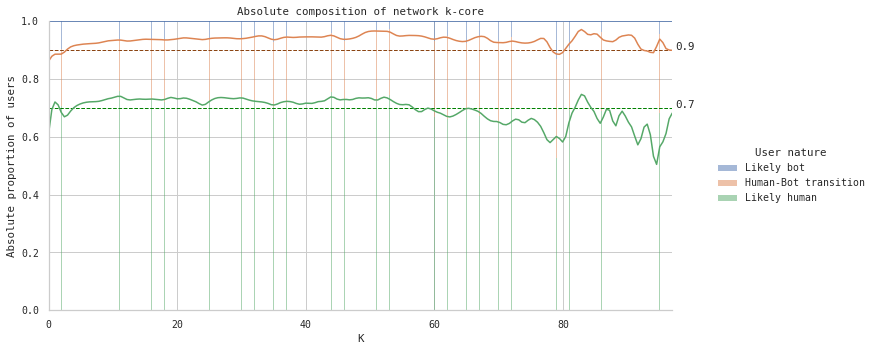

In [50]:
%%time
ax = sns.displot(data=df_cores,
                x='k-core', 
                hue='User nature',
                kde=True,
                multiple="fill",
                hue_order=['Likely bot','Human-Bot transition', 'Likely human'],
                height=5,
                aspect=2,
                facet_kws={'legend_out':True}
                )

plt.title('Absolute composition of network k-core')
#ax.add_legend(loc='lower right')
ax.set_axis_labels("K", "Absolute proportion of users")

colors={prs[0]:'green',
        prs[1]:'saddlebrown'}
h_xlims = ax.ax.get_xlim()
for pr,p in zip(prs,ps):
    ax.ax.hlines(y=pr/100, xmin=h_xlims[0], xmax=h_xlims[1], linewidth = 1, linestyles='dashed',color=colors[pr])
    text(y=pr/100+0.01, x=h_xlims[1]+0.5, s= str(pr/100), verticalalignment='center')

ax.tight_layout()
ax.savefig('images/kcores-fill.svg', bbox_inches = "tight")

CPU times: user 2.54 s, sys: 3.53 s, total: 6.07 s
Wall time: 1.06 s


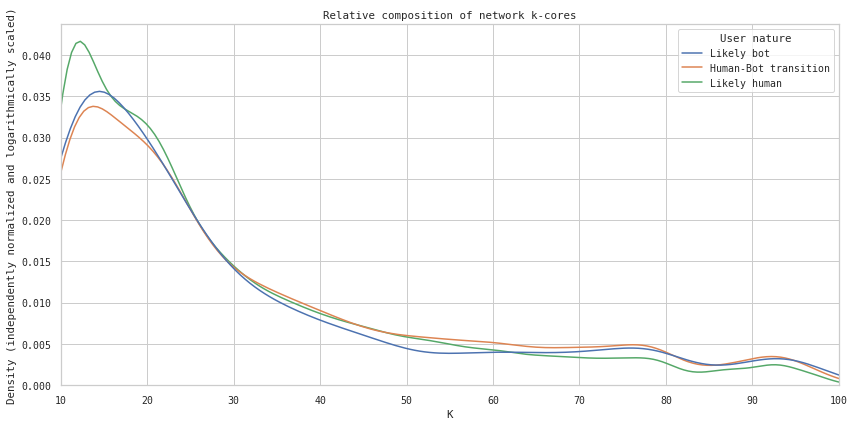

In [55]:
%%time

fig, axs = plt.subplots(1, 1, figsize=(12,6))

ax = sns.kdeplot(data=df_cores[df_cores['k-core']>=10],
                   x='k-core', 
                   hue='User nature',
                   common_norm=False,
                   #stat='probability',
                   #kde=True,
                   hue_order=['Likely bot','Human-Bot transition', 'Likely human'],
                   log_scale=[False, False],
                   #multiple='stack',
                   #height=3,
                   #aspect=3,
                )

plt.title('Relative composition of network k-cores')
plt.xlim(10,100)
ax.set_xlabel("K")
ax.set_ylabel("Density (independently normalized and logarithmically scaled)")
plt.tight_layout()
plt.savefig('images/kcores-relative.svg', bbox_inches = "tight")